$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$


### <font color=green size=20> MRI Simulator

In [1]:
from os.path import dirname, join as pjoin
import scipy.io as sio

import unittest
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from fastMRI.data import transforms as Ttorch

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [2]:
data_dir = pjoin(dirname(sio.__file__), 'data')
mat_fname = pjoin(data_dir, 'fat-water@3T-3echo')

In [3]:
print(data_dir)
print(mat_fname)

C:\Users\apahima\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\io\data
C:\Users\apahima\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\io\data\fat-water@3T-3echo


### Loading matrix and set B0 transfer field

In [4]:
mat_contents = sio.loadmat(mat_fname)
B0_low = 0.3;

In [5]:
sorted(mat_contents.keys())

['TE', '__globals__', '__header__', '__version__', 'k_high', 'n_cov']

## Check for loading correctly

In [6]:
print('N_cov shape',(mat_contents['n_cov'].shape))
print('k_rad shape',(mat_contents['k_high'].shape))
print('T shape',(mat_contents['TE'].shape))

N_cov shape (8, 8)
k_rad shape (168, 168, 1, 3, 8)
T shape (1, 3)


In [7]:
# mat_contents['TE'] = mat_contents['TE'].squeeze(0)
# print('TE Shape:',mat_contents['TE'].shape)

# print((mat_contents['N_cov'][0]))

### Create cpmlex tensors for later

In [8]:
k_high_T = Ttorch.to_tensor(mat_contents['k_high'])

print('k_high Tensor shape:',k_high_T.shape)

k_high Tensor shape: torch.Size([168, 168, 1, 3, 8, 2])


In [9]:
inParam = {'B_high' : 3, 'B_low' : B0_low ,'tissue' : 'liver' ,'sequence' : 'GradientEcho','theta' : 3,'BW_high' : 62.5,
           'BW_low' : 62.5 ,'TR_high' : 9.0 ,'TR_low' : 4.6, 'n_cov' : mat_contents['n_cov']}

# inParam['TE_high'] = 2.6
# inParam['TE_low'] = 2.6
inParam['BW_low'] = inParam['BW_high'] * B0_low/3
inParam['TR_low'] = mat_contents['TE'][0][-1] * 1000 * 3/B0_low + 1/inParam['BW_low']/2 + 5.608

In [10]:
k_low = torch.zeros_like(k_high_T)
print('k_low Tensor with two channels size:', k_low.shape)

k_low Tensor with two channels size: torch.Size([168, 168, 1, 3, 8, 2])


## Import the main functions

In [11]:
import Function.lowfieldgen as Klow
import Function.gridkb 
import Function.elementwise_mul_abs_complex

manipol = Klow.lowfieldgen()  #This is a clsass so it must be loaded with ()
gridkb = Function.gridkb.gridkb #This is function so it not neccessery to load it with ()
elementwise_mul_abs_complex = Function.elementwise_mul_abs_complex.elementwise_mul_abs_complex
elementwise_mul_abs_complex2 = Function.elementwise_mul_abs_complex.elementwise_mul_abs_complex2

In [12]:
# k_low[Nkx Nky Nkz Nt Ncoil Complex]
for i in range(0,3):
    inParam['k_high'] = k_high_T[:,:,:,i,:,:]
    inParam['TE_high'] = mat_contents['TE'][0][i] * 1000
    inParam['TE_low']   = mat_contents['TE'][0][i] * 1000 * 3/B0_low
    k_low[:,:,:,i,:,:] = manipol.klow(inParam)

T1_high 0.81
T1_low 0.27
T2: 0.043
eig torch.Size([8, 8, 2])
noise shape torch.Size([168, 168, 1, 8, 2])
K_high shape torch.Size([168, 168, 1, 8, 2])
T1_high 0.81
T1_low 0.27
T2: 0.043
eig torch.Size([8, 8, 2])
noise shape torch.Size([168, 168, 1, 8, 2])
K_high shape torch.Size([168, 168, 1, 8, 2])
T1_high 0.81
T1_low 0.27
T2: 0.043
eig torch.Size([8, 8, 2])
noise shape torch.Size([168, 168, 1, 8, 2])
K_high shape torch.Size([168, 168, 1, 8, 2])


In [13]:
print(k_high_T.shape)
print(k_low.shape)
size_k_low = torch.tensor(168.0)

torch.Size([168, 168, 1, 3, 8, 2])
torch.Size([168, 168, 1, 3, 8, 2])


In [14]:
k_high_T = k_high_T.permute(2,3,4,0,1,5) #permute to orgenize it to feed it thru the ifft2 function
print(k_high_T.shape)

k_low = k_low.permute(2,3,4,0,1,5) #permute to orgenize it to feed it thru the ifft2 function
print(k_low.shape)

torch.Size([1, 3, 8, 168, 168, 2])
torch.Size([1, 3, 8, 168, 168, 2])


In [15]:
recon_high = torch.sqrt(size_k_low*size_k_low)*Ttorch.ifft2_MRI_7T3(k_high_T)
recon_low = torch.sqrt(size_k_low*size_k_low)*Ttorch.ifft2_MRI_7T3(k_low)


print(recon_high.shape)
recon_high = recon_high.permute(3,4,0,1,2,5)
print(recon_high.shape)

print(recon_low.shape)
recon_low = recon_low.permute(3,4,0,1,2,5)
print(recon_low.shape)



torch.Size([1, 3, 8, 168, 168, 2])
torch.Size([168, 168, 1, 3, 8, 2])
torch.Size([1, 3, 8, 168, 168, 2])
torch.Size([168, 168, 1, 3, 8, 2])


In [16]:
recon_high = recon_high[:,:,:,0,:,:]
print(recon_high.shape)

recon_low = recon_low[:,:,:,0,:,:]
print(recon_low.shape)

torch.Size([168, 168, 1, 8, 2])
torch.Size([168, 168, 1, 8, 2])


In [17]:
# print(recon_low[:5,:5,0,0,:,:])

In [18]:
# abs_power_2 = elementwise_mul_abs_complex(recon_high)

# print(abs_power_2.shape)
# print(abs_power_2[:5,:5,0])

In [19]:
img_high_combined =torch.sum(elementwise_mul_abs_complex(recon_high),3)
print(img_high_combined.shape)


img_low_combined =torch.sum(elementwise_mul_abs_complex(recon_low),3)
print(img_low_combined.shape)

torch.Size([168, 168, 1])
torch.Size([168, 168, 1])


Text(0.5, 1.0, 'Simulated @ 0.3 T')

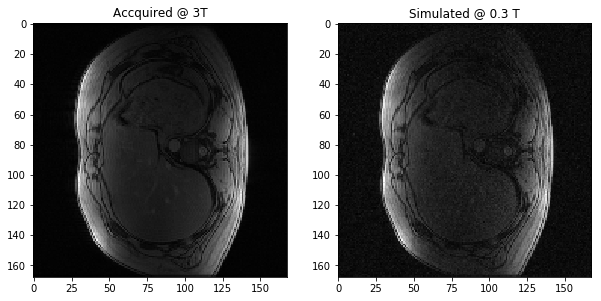

In [21]:
plt.figure(figsize=(10, 10))
        

# accquired
plt.subplot(121),
plt.imshow(np.sqrt(abs(img_high_combined[:,:,0])),cmap='gray')
plt.title('Accquired @ 3T')

# low field
plt.subplot(122),
plt.imshow(np.sqrt(abs(img_low_combined[:,:,0])),cmap='gray');
plt.title("Simulated @ %s T" %inParam['B_low'])

In [ ]:
(mat_contents['cv'][0][0][3][0][0])

inParam['k_high'] = torch.reshape(k_high_T, (mat_contents['cv'][0][0][1][0][0],mat_contents['cv'][0][0][2][0][0],1,1,mat_contents['cv'][0][0][3][0][0],2))
print('k_high shape:', inParam['k_high'].shape)
# print('k_high shape:', inParam['k_high'][0][0][0][0][2])  Check for right convert

In [ ]:
#n_cov is the coils noise matrix covariance so actually is the machine state and don't need to back propogate during the learning procedure 
print(inParam.keys())

In [ ]:
k_low = manipol.klow(inParam)

In [ ]:
cvNkx = mat_contents['cv'][0][0][1][0][0]
cvNky = mat_contents['cv'][0][0][2][0][0]
cvNcoil = mat_contents['cv'][0][0][3][0][0]


k_rad_low = torch.reshape(k_low, (mat_contents['cv'][0][0][1][0][0],mat_contents['cv'][0][0][2][0][0],mat_contents['cv'][0][0][3][0][0],2))
k_rad_high = torch.reshape(inParam['k_high'], (mat_contents['cv'][0][0][1][0][0],mat_contents['cv'][0][0][2][0][0],mat_contents['cv'][0][0][3][0][0],2))

print('cvNkx',cvNkx)
print('cvNky',cvNky)
print('cvNcoil',cvNcoil)
print('k_low shape:', k_rad_low.shape)
print('k_high shape:', k_rad_high.shape)

## Recon parameters

In [ ]:
windowsize = 21
viewinterval = 21

maxFrame = (np.floor(np.divide((k_rad_low.size())[1],windowsize)) - 1).astype(int)

print('Maximum frames to be recontructed is:', maxFrame)
init_frame = 11
if init_frame < 0 or init_frame > maxFrame:
    raise ValueError('wrong init_frame!')

final_frame = 11
if final_frame < init_frame or final_frame > maxFrame:
    raise ValueError('wrong final_frame!')
    
    
tot_frame = final_frame - init_frame + 1
print('Reconstructing from frame',init_frame,'to', final_frame)

frameshow = tot_frame
if frameshow > tot_frame:
     raise ValueError('wrong frameshow!')

os = torch.tensor(2, dtype=torch.double)            # Oversampling factor in gridding
kernalsize = 2*os # *os to be in oversampled grid

In [ ]:
tot_spoke = (k_rad_low.size())[1]

if tot_frame > 0:
    print('Total frame:',tot_frame)
    # do nothing, use specified tot_frame
else:
    if windowsize >= viewinterval:
        tot_frame = np.floor((tot_spoke-windowsize)/viewinterval)
    else:
        tot_frame = np.floor(tot_spoke/(viewinterval));


In [ ]:
img_low = torch.zeros(cvNkx*os.int(),cvNkx*os.int(),cvNcoil,tot_frame,2)
img_high = torch.zeros(cvNkx*os.int(),cvNkx*os.int(),cvNcoil,tot_frame,2)
imgsize = torch.tensor(cvNkx.astype(int))

In [ ]:
# print('img_low',img_low.size())
# print('img_high',img_high.size())
# print('imgsize',imgsize.size())

In [ ]:
T_tensor = Ttorch.to_tensor(mat_contents['T'])
W_tensor = torch.tensor(mat_contents['W'])
                        
print('T_tensor shape:', T_tensor.size())
print('W_tensor shape:', W_tensor.size())

In [ ]:
for tempframe in range(init_frame,final_frame+1):
    print(tempframe)
    cur_T = T_tensor[:,(tempframe*viewinterval):(tempframe*viewinterval + windowsize),:]
    cur_W = W_tensor[:,(tempframe*viewinterval):(tempframe*viewinterval + windowsize)]
    cur_k_rad_low = k_rad_low[:,(tempframe*viewinterval) :(tempframe*viewinterval + windowsize),:,:]
    cur_k_rad_high = k_rad_high[:,(tempframe*viewinterval) :(tempframe*viewinterval + windowsize),:,:]
#     print('cur_T',cur_T[-1,-1,:])
#     print('cur_W',cur_W[-1,-1])
#     print('cur_k_rad_high',cur_k_rad_high[-1,-1])
    
#     print('cur_T size:', cur_T.size())
#     print('cur_W size:', cur_W.size())
#     print('cur_k_rad_low size:', cur_k_rad_low.size())
#     print('cur_k_rad_high size:', cur_k_rad_high.size())
    
    print('img_high',img_high.size()) 
    print('')
    for coil in range(0,cvNcoil):
        print('coil',coil)
        img_low[:,:,coil,(tempframe - init_frame),:] = gridkb(cur_k_rad_low[:,:,coil,:],cur_T,cur_W,imgsize,os,kernalsize,'image')
        img_high[:,:,coil,(tempframe - init_frame),:] = gridkb(cur_k_rad_high[:,:,coil,:],cur_T,cur_W,imgsize,os,kernalsize,'image')
#         print(img_high[0,0,0,:,:])
    print('Reconstructing frame', tempframe)

In [ ]:
print(torch.sum(elementwise_mul_abs_complex(img_low),2).size())

In [ ]:
print('Displaying from frame',init_frame,'to', init_frame + frameshow -1)

# Lowfield
# print(Ttorch.complex_abs(img_low).size())
img_low_combined = torch.sqrt(torch.sum(elementwise_mul_abs_complex(img_low),2))
# img_low_combined = permute(img_low_combined, [ 1 2 4 3])
img_low_combined = img_low_combined[129:(128+256) , 129:(128+256),:]

#Accquired
img_high_combined = torch.sqrt(torch.sum(elementwise_mul_abs_complex(img_high),2))
# img_high_combined = permute(img_high_combined, [ 1 2 4 3])
img_high_combined = img_high_combined[128:(128+256) , 128:(128+256),:]


print(img_high_combined.size())


In [ ]:
if(frameshow > 0):
    for tempframe in range(0, frameshow):
        plt.figure(figsize=(10, 10))
        
        # accquired
        plt.subplot(121),
        plt.imshow(abs(img_high_combined[:,:,tempframe]),cmap='gray')
        plt.title('Accquired @ 3T')
        
        # low field
        plt.subplot(122),
        plt.imshow(abs(img_low_combined[:,:,tempframe]),cmap='gray');
        plt.title("Simulated @ %s T" %inParam['B_low'])